In [3]:
import os
from tqdm import tqdm
import json
import pandas as pd
import yaml

from functools import lru_cache
import math

import matplotlib.pyplot as plt

In [2]:
@lru_cache(maxsize=None)
def count_entries(file_path):
    """Count entries in a JSON or JSONL file."""
    try:
        if file_path.endswith('.json'):
            with open(file_path, 'r') as f:
                data = json.load(f)
                return len(data)
        elif file_path.endswith('.jsonl'):
            count = 0
            with open(file_path, 'r') as f:
                for _ in f:
                    count += 1
            return count
        else:
            raise ValueError(f"Unsupported file type: {file_path}")
    except Exception as e:
        print(f"Error counting entries in {file_path}: {e}")
        return 0

def calculate_sampled_count(sampling_strategy, total):
    """Calculate sampled count based on strategy."""
    if sampling_strategy == "all":
        return total

    strategy, value = sampling_strategy.split(":")

    if "%" in value:
        percentage = int(value.replace("%", ""))
        return math.ceil(total * percentage / 100)
    else:
        return min(int(value), total)

In [9]:
total_samples = clean_ov_df['total_samples'].sum()
print(f"Total samples: {total_samples:,}")

Total samples: 4,238,966


In [10]:
def calculate_new_strategies(df, target_total):
    """
    Calculate new sampling strategies that maintain relative proportions
    while reducing total samples to target_total.

    Args:
        df: DataFrame with columns ['source', 'sampling_strategy', 'total_samples', 'sampled_samples']
        target_total: Desired total number of samples after resampling

    Returns:
        DataFrame with new_sampling_strategy and new_sampled_samples columns
    """
    # Calculate original proportions and total
    original_total = df['sampled_samples'].sum()
    df['proportion'] = df['sampled_samples'] / original_total

    # Calculate new allocations
    df['new_sampled_samples'] = (df['proportion'] * target_total).round().astype(int)

    def _create_new_strategy(row):
        strategy_type, strategy_val = row['sampling_strategy'].split(':') if ':' in row['sampling_strategy'] else (row['sampling_strategy'], None)

        # Calculate needed percentage/number
        needed = row['new_sampled_samples']
        total = row['total_samples']

        # Preserve original strategy type where possible
        if strategy_val and '%' in strategy_val:
            # Original was percentage based --> use absolute number
            return f"{strategy_type}:{needed}"
        elif strategy_val and strategy_val.isdigit():
            # Original was absolute number based
            return f"{strategy_type}:{needed}"
        else:
            # Handle 'all' strategy or other special cases
            if needed == total:
                return 'all'
            return f"random:{needed}"

    # Apply strategy conversion
    df['new_sampling_strategy'] = df.apply(_create_new_strategy, axis=1)

    return df

# Calculate original total samples
original_total = clean_ov_df['sampled_samples'].sum()

# Set target total (e.g., reduce by 50%)
target_total = 50_000

# Apply the function
result_df = calculate_new_strategies(clean_ov_df, target_total)

# Show results
print(result_df[['source', 'sampling_strategy', 'new_sampling_strategy',
                'sampled_samples', 'new_sampled_samples']])

# Verify new total
print(f"\nOriginal total: {original_total}")
print(f"New total: {result_df['new_sampled_samples'].sum()} (target: {target_total})")

              source sampling_strategy new_sampling_strategy  sampled_samples  \
0         llava_next         first:50%            first:9043           369295   
1      llava_ov_data         first:10%             first:214             8735   
2      llava_ov_data         first:10%             first:245             9999   
3      llava_ov_data               all            random:119             4864   
4      llava_ov_data               all            random:108             4394   
..               ...               ...                   ...              ...   
65       m4_instruct               all          random:15079           615814   
66  llava_video_178k               all           random:1187            48468   
67  llava_video_178k               all            random:141             5753   
68  llava_video_178k               all           random:6244           255000   
69  llava_video_178k               all           random:1187            48468   

    new_sampled_samples  
0

/tmp/ipykernel_242344/1797951810.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([f'{int(tick)}k' for tick in ax1.get_yticks()])


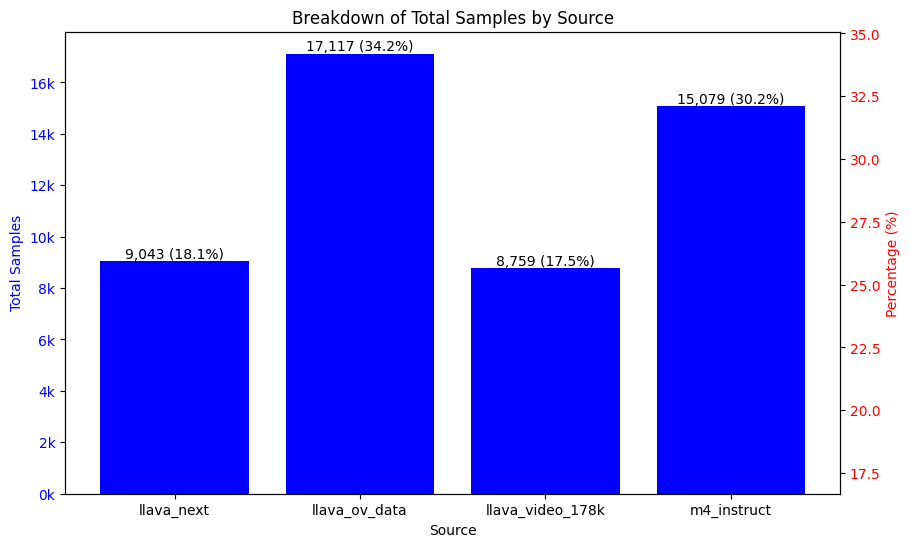

In [17]:
# Group by source and sum the total samples
source_total_samples = result_df.groupby('source')['new_sampled_samples'].sum()

# Calculate the percentage
total_samples_sum = source_total_samples.sum()
source_total_percentage = (source_total_samples / total_samples_sum) * 100

# Plot the breakdown
fig, ax1 = plt.subplots(figsize=(10, 6))

# Convert total samples to units of 1K
source_total_samples_k = source_total_samples / 1000

bars = ax1.bar(source_total_samples_k.index, source_total_samples_k, color='b')
ax1.set_xlabel('Source')
ax1.set_ylabel('Total Samples', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Add "k" to each left axis label
ax1.set_yticklabels([f'{int(tick)}k' for tick in ax1.get_yticks()])

# Create a secondary y-axis to plot the percentage
ax2 = ax1.twinx()
ax2.plot(source_total_samples_k.index, source_total_percentage, color='r', marker='o', alpha=0)
ax2.set_ylabel('Percentage (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add labels to the top of the bars
for bar, num_samples, pct in zip(bars, source_total_samples, source_total_percentage):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(num_samples):,} ({pct:.1f}%)', ha='center', va='bottom')

plt.title('Breakdown of Total Samples by Source')
plt.show()

In [61]:
def create_balanced_mix(original_df, new_entries_yaml, new_data_percentage, target_total):
    """
    Create a new data mix where new datasets make up specified percentage of total,
    while maintaining original proportions between existing sources, and ensuring
    the final total matches target_total exactly.

    Args:
        original_df: Existing DataFrame with data sources
        new_entries_yaml: YAML string with new entries to add
        new_data_percentage: Percentage (0-100) that new data should occupy in final mix
        target_total: Desired total number of samples in final mix

    Returns:
        Tuple of (combined_df, original_adjusted_df, new_df)
    """
    # Process new entries
    new_data = yaml.safe_load(new_entries_yaml)['datasets']
    new_df = pd.DataFrame(new_data)
    new_df["source"] = new_df["json_path"].str.split("/").str[-2]

    # Calculate samples for new data
    new_df['total_samples'] = new_df['json_path'].apply(count_entries)
    new_df['sampled_samples'] = new_df.apply(
        lambda row: calculate_sampled_count(row['sampling_strategy'], row['total_samples']),
        axis=1
    )

    # Determine how many samples should come from new data
    target_new_data = int(round((new_data_percentage / 100.0) * target_total))
    target_original_data = target_total - target_new_data

    # Scale new data to meet the target_new_data
    new_data_total = new_df['sampled_samples'].sum()
    if new_data_total > 0:
        scale_factor_new = target_new_data / new_data_total
    else:
        scale_factor_new = 0
    new_df['new_sampled_samples'] = (new_df['sampled_samples'] * scale_factor_new).round().astype(int)

    # Scale original data to meet the remaining samples
    original_adjusted_df = original_df.copy()
    original_total = original_adjusted_df['sampled_samples'].sum()
    if original_total > 0:
        scale_factor_original = target_original_data / original_total
    else:
        scale_factor_original = 0
    original_adjusted_df['new_sampled_samples'] = (
        original_adjusted_df['sampled_samples'] * scale_factor_original
    ).round().astype(int)

    # Create new sampling strategies for the original data
    def update_strategy(row):
        needed = row['new_sampled_samples']
        total = row['total_samples']
        strategy, val = row['sampling_strategy'].split(':') if ':' in row['sampling_strategy'] else (row['sampling_strategy'], None)
        if val and '%' in val:
            return f"{strategy}:{needed}"
        elif val and val.isdigit():
            return f"{strategy}:{needed}"
        else:
            if needed == total:
                return 'all'
            return f"random:{needed}"

    original_adjusted_df['new_sampling_strategy'] = original_adjusted_df.apply(update_strategy, axis=1)

    # update the new_data sampling strategies
    new_df['new_sampling_strategy'] = new_df.apply(update_strategy, axis=1)

    # Combine datasets
    combined_df = pd.concat([
        original_adjusted_df[['source', 'json_path', 'new_sampling_strategy', 'new_sampled_samples']]
        .rename(columns={'new_sampling_strategy': 'sampling_strategy', 'new_sampled_samples': 'sampled_samples'}),
        new_df[['source', 'json_path', 'new_sampling_strategy', 'new_sampled_samples']]
        .rename(columns={'new_sampling_strategy': 'sampling_strategy', 'new_sampled_samples': 'sampled_samples'})
    ], ignore_index=True)

    return combined_df, original_adjusted_df, new_df


## Jan 17 data

In [107]:
# new_entries_yaml = """
# datasets:
#   - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/combined_llava_ov_train_mc.jsonl
#     llava_json_path: .nan
#     sampling_strategy: random:100%
#   - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/combined_llava_ov_train_oe.jsonl
#     llava_json_path: .nan
#     sampling_strategy: random:50%
# """

new_entries_yaml = """
datasets:
# MC
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_descriptive_binary_mc.jsonl
    sampling_strategy: random:100%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_obj_count_mc.jsonl
    sampling_strategy: random:100%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_obj_rel_direction_mc.jsonl
    sampling_strategy: random:100%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_obj_rel_distance_mc.jsonl
    sampling_strategy: random:100%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_temporal_rel_mc.jsonl
    sampling_strategy: random:100%

# OE
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_descriptive_binary_oe.jsonl
    sampling_strategy: random:50%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_obj_count_oe.jsonl
    sampling_strategy: random:50%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_obj_rel_direction_oe.jsonl
    sampling_strategy: random:50%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_obj_rel_distance_oe.jsonl
    sampling_strategy: random:50%
  - json_path: /data/weka/ellisb/vida/experiment_output/dataset/jan17/spoc_train_mt1_temporal_rel_oe.jsonl
    sampling_strategy: random:50%
"""

target_percentage = 100
target_total_samples = 50_000

# Create mix where new data makes up X% of total
combined_df, original_adjusted_df, new_df = create_balanced_mix(
    clean_ov_df,
    new_entries_yaml,
    new_data_percentage=target_percentage,
    target_total=target_total_samples
)

# Show results
# print("Combined Data Mix:")
# print(combined_df[['source', 'sampling_strategy', 'sampled_samples']])
# print("\nOriginal Data Adjusted:")
# print(original_adjusted_df[['source', 'sampling_strategy', 'new_sampling_strategy', 'sampled_samples', 'new_sampled_samples']])
# print("\nNew Data:")
# print(new_df[['source', 'sampling_strategy', 'sampled_samples']])

# Verify percentages
total_samples = combined_df['sampled_samples'].sum()
new_data_percent = (new_df['sampled_samples'].sum() / total_samples) * 100
# print(f"\nNew data makes up {new_data_percent:.1f}% of total {total_samples} samples")

In [108]:
combined_df

,source,json_path,sampling_strategy,sampled_samples
0,llava_next,/data/weka/ellisb/datasets/video/llava_next/ll...,first:0,0
1,llava_ov_data,/data/weka/ellisb/datasets/video/llava_ov_data...,first:0,0
2,llava_ov_data,/data/weka/ellisb/datasets/video/llava_ov_data...,first:0,0
3,llava_ov_data,/data/weka/ellisb/datasets/video/llava_ov_data...,random:0,0
4,llava_ov_data,/data/weka/ellisb/datasets/video/llava_ov_data...,random:0,0
...,...,...,...,...
75,jan17,/data/weka/ellisb/vida/experiment_output/datas...,random:3599,3599
76,jan17,/data/weka/ellisb/vida/experiment_output/datas...,random:2728,2728
77,jan17,/data/weka/ellisb/vida/experiment_output/datas...,random:3388,3388
78,jan17,/data/weka/ellisb/vida/experiment_output/datas...,random:3380,3380


/tmp/ipykernel_242344/2326808684.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([f'{int(tick)}k' for tick in ax1.get_yticks()])


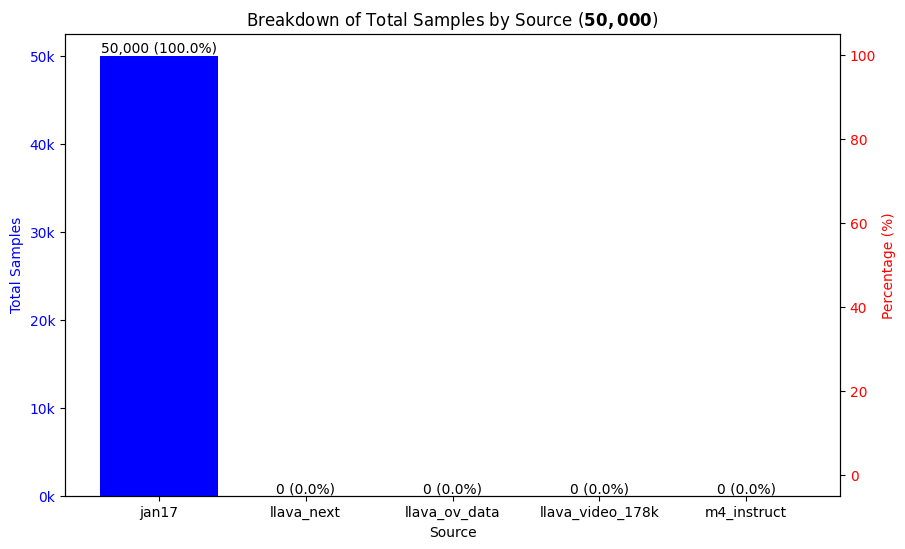

In [109]:
# Group by source and sum the total samples
source_total_samples = combined_df.groupby('source')['sampled_samples'].sum()

# Calculate the percentage
total_samples_sum = source_total_samples.sum()
source_total_percentage = (source_total_samples / total_samples_sum) * 100

# Plot the breakdown
fig, ax1 = plt.subplots(figsize=(10, 6))

# Convert total samples to units of 1K
source_total_samples_k = source_total_samples / 1000

bars = ax1.bar(source_total_samples_k.index, source_total_samples_k, color='b')
ax1.set_xlabel('Source')
ax1.set_ylabel('Total Samples', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Add "k" to each left axis label
ax1.set_yticklabels([f'{int(tick)}k' for tick in ax1.get_yticks()])

# Create a secondary y-axis to plot the percentage
ax2 = ax1.twinx()
ax2.plot(source_total_samples_k.index, source_total_percentage, color='r', marker='o', alpha=0)
ax2.set_ylabel('Percentage (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add labels to the top of the bars
for bar, num_samples, pct in zip(bars, source_total_samples, source_total_percentage):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(num_samples):,} ({pct:.1f}%)', ha='center', va='bottom')

plt.title(f'Breakdown of Total Samples by Source ($\mathbf{{{total_samples_sum:,}}}$)')

plt.show()

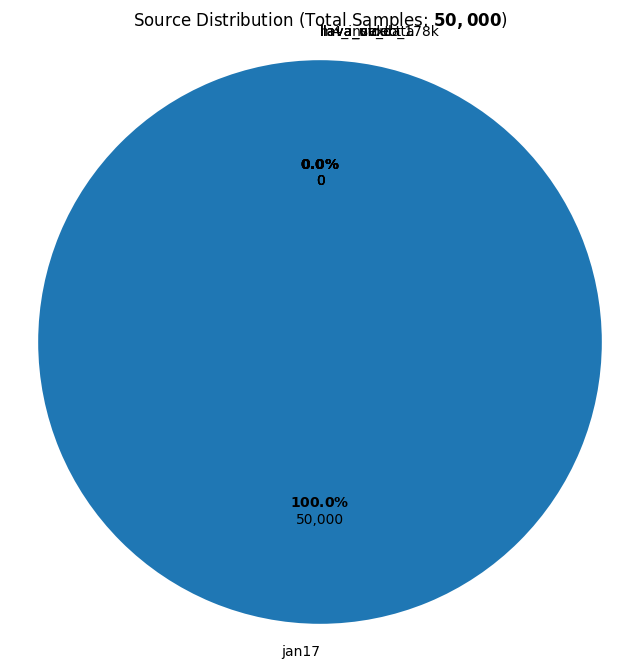

In [110]:
import seaborn as sns

# Use a seaborn palette for a nicer look
# sns.set_palette("Set1")
sns.set_palette("tab20")

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    source_total_samples,
    labels=source_total_samples.index,
    autopct='%1.1f%%',
    startangle=90
)

for i, autotext in enumerate(autotexts):
    num_samples = source_total_samples.iloc[i]
    pct = source_total_percentage.iloc[i]
    autotext.set_text(f"$\\mathbf{{{pct:.1f}\\%}}$\n{num_samples:,}")

ax.axis('equal')
grand_total = source_total_samples.sum()
plt.title(rf"Source Distribution (Total Samples: $\mathbf{{{grand_total:,}}}$)")
plt.show()

# save the plot to a file
ov_pct = 100 - target_percentage
combined_data_path = f"../ai2/exp/2025_02_05_ovmixin_50k/ov{ov_pct}pct_{target_total_samples//1000}k_samples.png"
os.makedirs(os.path.dirname(combined_data_path), exist_ok=True)
fig.savefig(combined_data_path)

In [111]:
# save the new data mix to a yaml file
ov_pct = 100 - target_percentage
combined_data_path = f"../ai2/exp/2025_02_05_ovmixin_50k/ov{ov_pct}pct.yaml"
os.makedirs(os.path.dirname(combined_data_path), exist_ok=True)
with open(combined_data_path, 'w') as f:
    yaml.safe_dump({"datasets": combined_df.to_dict(orient='records')}, f)
print(f'Saved combined data mix to "./{combined_data_path}"')

Saved combined data mix to "./../ai2/exp/2025_02_05_ovmixin_50k/ov0pct.yaml"
